In [1]:
from pynta.postprocessing import *
from ase.visualize import view
import json
import os

Found many potential paths for FW_CONFIG_FILE: ['/projects/westgroup/lekia.p/pynta_pr/FW_config.yaml', '/projects/westgroup/lekia.p/pynta/FW_config.yaml']
Choosing as default: /projects/westgroup/lekia.p/pynta_pr/FW_config.yaml


# Surface Information and Reference Energies

In [2]:
path = "/projects/westgroup/lekia.p/pynta_pr/Fe/Fe_with_Fairchem"

#Surface information
metal = "Fe" #specify the metal
facet = "bcc110" #specify the facet
slab = read("/projects/westgroup/lekia.p/pynta_pr/Fe/slab.xyz")
nslab = len(slab)
site_density = get_site_density(slab,metal,facet)

#Site Information
cas = SlabAdsorptionSites(slab, facet,allow_6fold=False,composition_effect=False,
                            label_sites=True,
                            surrogate_metal=metal)
sites = cas.get_sites()
site_adjacency = cas.get_neighbor_site_list()

#Reference Energies
c_ref,o_ref,h_ref,n_ref,sym = get_reference_energies(os.path.join(path,"Adsorbates"),nslab)

In [3]:
get_reference_energies(os.path.join(path,"Adsorbates"),nslab)

(-1100.6012040970845,
 -2079.2808830358927,
 -31.306002607381693,
 -1537.8774385201332,
 ['H', 'C', 'O', 'N'])

# Analyze Species

In [4]:
ad_path = os.path.join(path,"Adsorbates","O[Pt]") #specify the path to the Pynta species directory

In [5]:
spcs = get_species(ad_path,os.path.split(ad_path)[0],metal,facet,slab,sites,site_adjacency,nslab,c_ref=c_ref,o_ref=o_ref,h_ref=h_ref,
               n_ref=n_ref) #all configurations
minspc = spcs[min({k:v for k,v in spcs.items() if v.valid},key=lambda x: spcs[x].energy)] #lowest energy valid configuration

In [6]:
print("Relative Energies of Configurations: {} [eV]".format({k:v.energy - minspc.energy for k,v in spcs.items()}))
print("Validity of Configurations: {}".format({k:v.valid for k,v in spcs.items()}))

Relative Energies of Configurations: {'0': 0.5799099440950499, '1': 0.0, '2': 0.010057274825669538, '3': 1.7393461367878444} [eV]
Validity of Configurations: {'0': True, '1': True, '2': True, '3': True}


In [10]:
#view(s.atoms for s in spcs.values()) #see all configurations

In [11]:
#Individual species
spc = minspc #or spc = spcs['0'] etc.

In [12]:
print("Frequencies: {} cm^-1".format(spc.vibdata.get_frequencies()))

Frequencies: [ 193.69390048+0.j  197.3104837 +0.j  318.30818325+0.j  521.37901976+0.j
  557.81638325+0.j 3573.70219557+0.j] cm^-1


In [13]:
print("Hf298: {} kcal/mol".format(spc.heat_of_formation_298K/4184.0))
print("Sf298: {} cal/(mol K)".format(spc.entropy_of_formation_298K/4.184))

Hf298: 47228.87438215474 kcal/mol
Sf298: 6.803983740839437 cal/(mol K)


In [14]:
#view(spc.atoms) #see individual configuration

In [15]:
#Specific Thermodynamic Properties J-mol-K
T = 1000.0
print("Gf(T={0}): {1} kcal/mol".format(T,spc.nasa.get_free_energy(T)/4184.0))
print("Hf(T={0}): {1} kcal/mol".format(T,spc.nasa.get_enthalpy(T)/4184.0))
print("Sf(T={0}): {1} cal/(mol K)".format(T,spc.nasa.get_entropy(T)/4.184))
print("Cp(T={0}): {1} cal/(mol K)".format(T,spc.nasa.get_heat_capacity(T)/4.184))

Gf(T=1000.0): 47217.622421298 kcal/mol
Hf(T=1000.0): 47235.364420903505 kcal/mol
Sf(T=1000.0): 17.74199960549986 cal/(mol K)
Cp(T=1000.0): 9.998370301279053 cal/(mol K)


# Analyze Transition State


In [16]:
ts_path = os.path.join(path,"TS3") #specify the TS directory to analyze

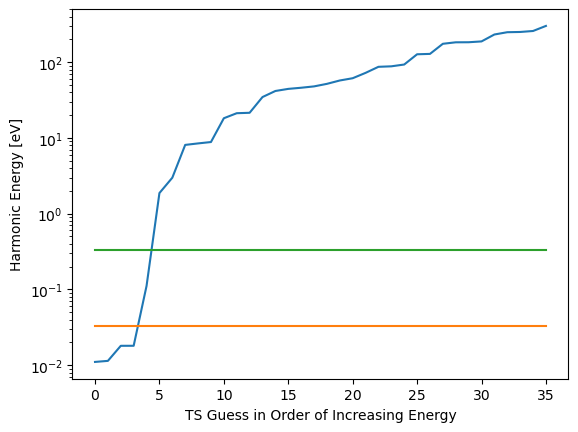

In [17]:
plot_eharm(ts_path,Eharmtol=3.0,Eharmfiltertol=30.0) #plot the harmonic energies of the transition state guesses and cutoffs 

In [18]:
kinetics = get_kinetics(ts_path,os.path.join(os.path.split(ts_path)[0],"Adsorbates"),metal,facet,slab,sites,site_adjacency,nslab,site_density,
                c_ref=c_ref,o_ref=o_ref,h_ref=0.0,n_ref=0.0)
minkinind = min({k:v for k,v in kinetics.items() if v.valid},key=lambda x: kinetics[x].barrier_f) #index of lowest energy valid configuration

In [19]:
print(kinetics[minkinind].reaction_str) #Reaction String

O[Pt] + vacantX <=> [Pt] + O=[Pt]


In [20]:
print("Forward Barriers: {} [eV]".format({k:v.barrier_f for k,v in kinetics.items()}))
print("Reverse Barriers: {} [eV]".format({k:v.barrier_r for k,v in kinetics.items()}))
print("Automated Validity Determination: {}".format({k:v.valid for k,v in kinetics.items()}))

Forward Barriers: {'10': 0.4842861957319826, '18': 0.6640245592363954, '22': 0.6639965267807213} [eV]
Reverse Barriers: {'10': 3.7500546580794207, '18': 3.9297930215838335, '22': 3.9297649891281594} [eV]
Automated Validity Determination: {'10': True, '18': True, '22': True}


In [21]:
#Individual Transition States/Kinetics
ind = minkinind #'7' etc.
kin = kinetics[ind]

In [22]:
print("Frequencies: {} cm^-1".format(kin.transition_state.vibdata.get_frequencies()))

Frequencies: [   0.        +1020.17775391j  174.93777347   +0.j
  214.59081866   +0.j          453.24854409   +0.j
  511.18765111   +0.j         1073.31368096   +0.j        ] cm^-1


In [23]:
kin.arr_f #Forward rate coefficient

SurfaceArrhenius(A=(7.15689e-09,'m^2/(molecule*s)'), n=0.658701, Ea=(46.6652,'kJ/mol'), T0=(1,'K'), Tmin=(298.15,'K'), Tmax=(2000,'K'), comment="""Fitted to 172 data points; dA = *|/ 1.01111, dn = +|- 0.00142408, dEa = +|- 0.00896879 kJ/mol""")

In [24]:
kin.arr_r #Reverse rate coefficient

SurfaceArrhenius(A=(9.11756e-22,'m^2/(molecule*s)'), n=5.54922, Ea=(355.93,'kJ/mol'), T0=(1,'K'), Tmin=(298.15,'K'), Tmax=(2000,'K'), comment="""Fitted to 172 data points; dA = *|/ 1.07651, dn = +|- 0.00949873, dEa = +|- 0.0598228 kJ/mol""")

In [25]:
#Specific Thermodynamic Properties J-mol-K
T = 1000.0
print("dGrxn(T={0}): {1} kcal/mol".format(T,kin.get_gibbs_energy_reaction(T)/4184.0))
print("dHrxn(T={0}): {1} kcal/mol".format(T,kin.get_enthalpy_reaction(T)/4184.0))
print("dSrxn(T={0}): {1} cal/(mol K)".format(T,kin.get_entropy_reaction(T)/4.184))

dGrxn(T=1000.0): -74.06766165551475 kcal/mol
dHrxn(T=1000.0): -74.9311702127068 kcal/mol
dSrxn(T=1000.0): -0.8635085571877404 cal/(mol K)


In [26]:
#Check TS Validity Information
kin.valid_info

{'TS_direct_Validation': True,
 'IRC_Validation': True,
 'One_Endpoint_Valid': True,
 'IRC_Endpoints_Match': False,
 'Short_IRC': False,
 'Struct Validation': True,
 'Freq Alignment Validation': True,
 'Reaction_Bond_Freq_Alignments': [1.3187296303884954],
 'Fixed_Bond_Freq_Alignments': []}

In [27]:
#Visualize TS
# view(read(os.path.join(ts_path,ind,"opt.xyz")))
ase.visualize.view(read(os.path.join(ts_path,ind,"opt.xyz")), viewer='x3d')

In [29]:
from ase.io import read
#Visualize IRC1 
view(Trajectory(os.path.join(ts_path,ind,"irc_forward.traj")))

In [30]:
#Visualize IRC2
view(Trajectory(os.path.join(ts_path,ind,"irc_reverse.traj")))

In [31]:
#Visualize Imaginary Frequency
view(Trajectory(os.path.join(ts_path,ind,"vib.0.traj")))